In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive/HackathonKiel')


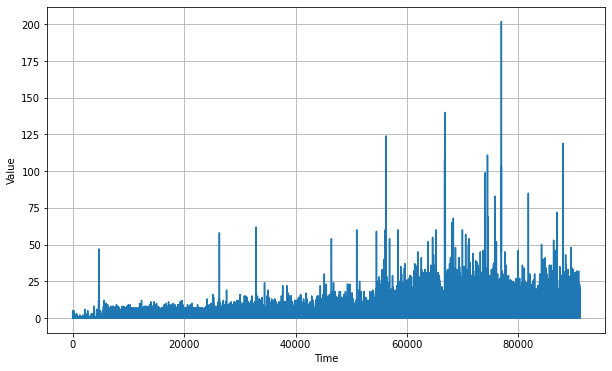

In [128]:
import csv
time_step = []
temps = []

with open('./timeseries_hourly.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps).astype("float64")
time = np.array(time_step).astype("float64")
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
time = time[60000:]
series = series[60000:]
time = time-60000

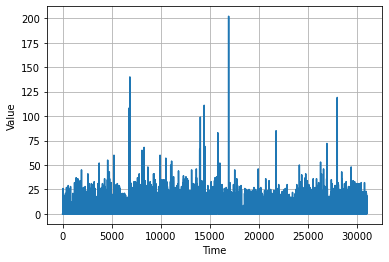

In [130]:
plot_series(time, series)

In [0]:
series[series>75] = 75

In [0]:
split_time = 24000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7*24
batch_size = 52
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [0]:
train_set.shape

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 7*24
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 70)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(24000,)
Epoch 1/10
459/459 [==============================] - 9s 20ms/step - loss: 3.2319 - mae: 3.6116 - lr: 1.0000e-06
Epoch 2/10
459/459 [==============================] - 9s 20ms/step - loss: 2.4697 - mae: 2.8130 - lr: 1.2589e-06
Epoch 3/10
459/459 [==============================] - 9s 20ms/step - loss: 2.2458 - mae: 2.5744 - lr: 1.5849e-06
Epoch 4/10
459/459 [==============================] - 9s 20ms/step - loss: 2.0837 - mae: 2.4035 - lr: 1.9953e-06
Epoch 5/10
459/459 [==============================] - 9s 20ms/step - loss: 1.9624 - mae: 2.2758 - lr: 2.5119e-06
Epoch 6/10
459/459 [==============================] - 9s 20ms/step - loss: 1.8746 - mae: 2.1851 - lr: 3.1623e-06
Epoch 7/10
459/459 [==============================] - 9s 20ms/step - loss: 1.8077 - mae: 2.1164 - lr: 3.9811e-06
Epoch 8/10
459/459 [==============================] - 9s 20ms/step - loss: 1.7484 - mae: 2.0558 - lr: 5.01

In [136]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 256)         16640     
_________________________________________________________________
dense_1 (Dense)              (None, None, 128)         32896     
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           129       
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 10))
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
459/459 [==============================] - 9s 19ms/step - loss: 1.5997 - mae: 1.9029 - lr: 1.0000e-05
Epoch 2/10
459/459 [==============================] - 9s 19ms/step - loss: 1.5624 - mae: 1.8631 - lr: 1.2589e-05
Epoch 3/10
459/459 [==============================] - 9s 20ms/step - loss: 1.5297 - mae: 1.8259 - lr: 1.5849e-05
Epoch 4/10
459/459 [==============================] - 9s 20ms/step - loss: 1.5019 - mae: 1.7940 - lr: 1.9953e-05
Epoch 5/10
459/459 [==============================] - 9s 20ms/step - loss: 1.4762 - mae: 1.7629 - lr: 2.5119e-05
Epoch 6/10
459/459 [==============================] - 9s 19ms/step - loss: 1.4504 - mae: 1.7339 - lr: 3.1623e-05
Epoch 7/10
459/459 [==============================] - 9s 20ms/step - loss: 1.4237 - mae: 1.7039 - lr: 3.9811e-05
Epoch 8/10
459/459 [==============================] - 9s 20ms/step - loss: 1.3984 - mae: 1.6752 - lr: 5.0119e-05
Epoch 9/10
459/459 [==============================] - 9s 20ms/step - loss: 1.3746 - mae: 1.6490 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 10))
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
459/459 [==============================] - 9s 20ms/step - loss: 1.3242 - mae: 1.5925 - lr: 1.0000e-04
Epoch 2/10
459/459 [==============================] - 9s 19ms/step - loss: 1.2967 - mae: 1.5609 - lr: 1.2589e-04
Epoch 3/10
459/459 [==============================] - 9s 20ms/step - loss: 1.2742 - mae: 1.5366 - lr: 1.5849e-04
Epoch 4/10
459/459 [==============================] - 9s 20ms/step - loss: 1.2601 - mae: 1.5260 - lr: 1.9953e-04
Epoch 5/10
459/459 [==============================] - 9s 20ms/step - loss: 1.2620 - mae: 1.5512 - lr: 2.5119e-04
Epoch 6/10
459/459 [==============================] - 9s 20ms/step - loss: 1.2683 - mae: 1.5740 - lr: 3.1623e-04
Epoch 7/10
459/459 [==============================] - 9s 20ms/step - loss: 1.2699 - mae: 1.5905 - lr: 3.9811e-04
Epoch 8/10
459/459 [==============================] - 9s 19ms/step - loss: 1.2540 - mae: 1.5704 - lr: 5.0119e-04
Epoch 9/10
459/459 [==============================] - 9s 20ms/step - loss: 1.2503 - mae: 1.5750 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4)
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1890 - mae: 1.4363 - lr: 1.0000e-04
Epoch 2/50
459/459 [==============================] - 9s 19ms/step - loss: 1.1708 - mae: 1.4096 - lr: 1.0000e-04
Epoch 3/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1649 - mae: 1.4032 - lr: 1.0000e-04
Epoch 4/50
459/459 [==============================] - 9s 19ms/step - loss: 1.1610 - mae: 1.3993 - lr: 1.0000e-04
Epoch 5/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1582 - mae: 1.3965 - lr: 1.0000e-04
Epoch 6/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1550 - mae: 1.3933 - lr: 1.0000e-04
Epoch 7/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1531 - mae: 1.3916 - lr: 1.0000e-04
Epoch 8/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1502 - mae: 1.3882 - lr: 1.0000e-04
Epoch 9/50
459/459 [==============================] - 9s 20ms/step - loss: 1.1489 - mae: 1.3870 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4)
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1430 - mae: 1.3741 - lr: 1.0000e-04
Epoch 2/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1287 - mae: 1.3584 - lr: 1.0000e-04
Epoch 3/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1235 - mae: 1.3529 - lr: 1.0000e-04
Epoch 4/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1198 - mae: 1.3493 - lr: 1.0000e-04
Epoch 5/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1167 - mae: 1.3462 - lr: 1.0000e-04
Epoch 6/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1142 - mae: 1.3433 - lr: 1.0000e-04
Epoch 7/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1119 - mae: 1.3408 - lr: 1.0000e-04
Epoch 8/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1095 - mae: 1.3384 - lr: 1.0000e-04
Epoch 9/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1069 - mae: 1.3356 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4)
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
459/459 [==============================] - 9s 20ms/step - loss: 1.1026 - mae: 1.3312 - lr: 1.0000e-04
Epoch 2/10
459/459 [==============================] - 9s 19ms/step - loss: 1.1003 - mae: 1.3290 - lr: 1.0000e-04
Epoch 3/10
459/459 [==============================] - 9s 19ms/step - loss: 1.0982 - mae: 1.3267 - lr: 1.0000e-04
Epoch 4/10
459/459 [==============================] - 9s 20ms/step - loss: 1.0965 - mae: 1.3248 - lr: 1.0000e-04
Epoch 5/10
459/459 [==============================] - 9s 20ms/step - loss: 1.0948 - mae: 1.3230 - lr: 1.0000e-04
Epoch 6/10
459/459 [==============================] - 9s 20ms/step - loss: 1.0931 - mae: 1.3214 - lr: 1.0000e-04
Epoch 7/10
459/459 [==============================] - 9s 20ms/step - loss: 1.0913 - mae: 1.3196 - lr: 1.0000e-04
Epoch 8/10
459/459 [==============================] - 9s 20ms/step - loss: 1.0895 - mae: 1.3176 - lr: 1.0000e-04
Epoch 9/10
459/459 [==============================] - 9s 20ms/step - loss: 1.0879 - mae: 1.3160 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4)
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0849 - mae: 1.3132 - lr: 1.0000e-04
Epoch 2/50
459/459 [==============================] - 9s 19ms/step - loss: 1.0831 - mae: 1.3106 - lr: 1.0000e-04
Epoch 3/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0820 - mae: 1.3096 - lr: 1.0000e-04
Epoch 4/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0800 - mae: 1.3072 - lr: 1.0000e-04
Epoch 5/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0791 - mae: 1.3067 - lr: 1.0000e-04
Epoch 6/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0766 - mae: 1.3038 - lr: 1.0000e-04
Epoch 7/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0760 - mae: 1.3032 - lr: 1.0000e-04
Epoch 8/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0744 - mae: 1.3015 - lr: 1.0000e-04
Epoch 9/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0731 - mae: 1.3001 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4)
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0245 - mae: 1.2508 - lr: 1.0000e-04
Epoch 2/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0227 - mae: 1.2492 - lr: 1.0000e-04
Epoch 3/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0214 - mae: 1.2476 - lr: 1.0000e-04
Epoch 4/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0196 - mae: 1.2448 - lr: 1.0000e-04
Epoch 5/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0185 - mae: 1.2442 - lr: 1.0000e-04
Epoch 6/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0173 - mae: 1.2428 - lr: 1.0000e-04
Epoch 7/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0157 - mae: 1.2408 - lr: 1.0000e-04
Epoch 8/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0150 - mae: 1.2403 - lr: 1.0000e-04
Epoch 9/50
459/459 [==============================] - 9s 20ms/step - loss: 1.0139 - mae: 1.2396 

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4)
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9588 - mae: 1.1818 - lr: 1.0000e-04
Epoch 2/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9575 - mae: 1.1808 - lr: 1.0000e-04
Epoch 3/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9564 - mae: 1.1791 - lr: 1.0000e-04
Epoch 4/50
459/459 [==============================] - 9s 19ms/step - loss: 0.9542 - mae: 1.1774 - lr: 1.0000e-04
Epoch 5/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9541 - mae: 1.1772 - lr: 1.0000e-04
Epoch 6/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9516 - mae: 1.1743 - lr: 1.0000e-04
Epoch 7/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9501 - mae: 1.1727 - lr: 1.0000e-04
Epoch 8/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9486 - mae: 1.1712 - lr: 1.0000e-04
Epoch 9/50
459/459 [==============================] - 9s 20ms/step - loss: 0.9471 - mae: 1.1693 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


ValueError: ignored

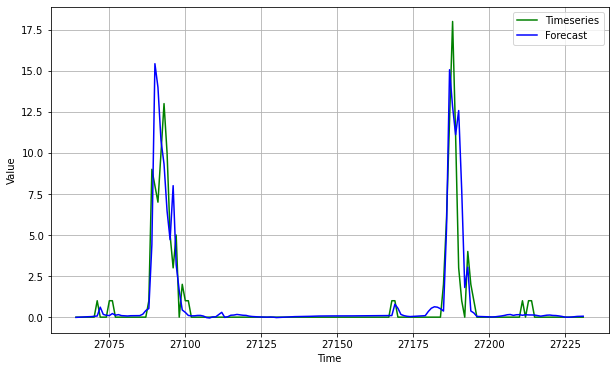

In [137]:
plt.figure(figsize=(10, 6))
start = 40 + 24*7*18
show_length = 24*7
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [0]:
import numpy as np

In [140]:
np.mean(np.(rnn_forecast-x_valid))

1.7478454431193022

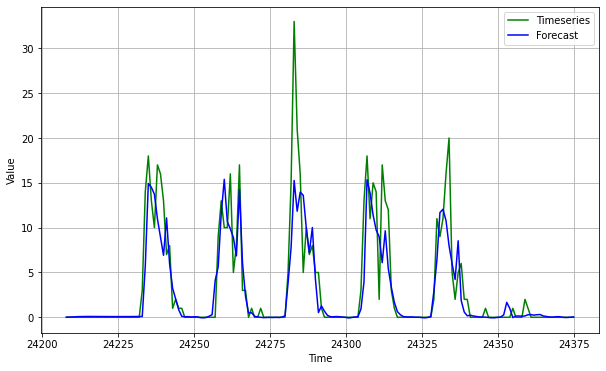

In [0]:
plt.figure(figsize=(10, 6))
start = 40 + 24*7*1
show_length = 24*7
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

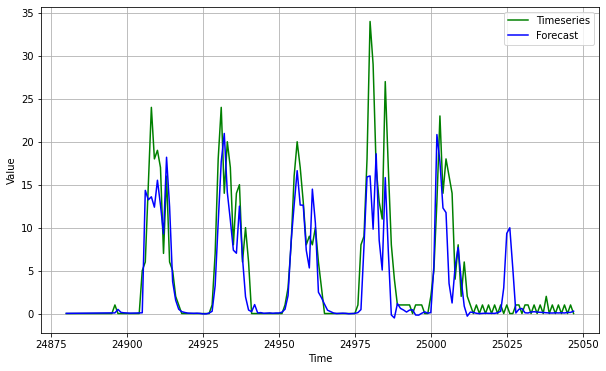

In [0]:
plt.figure(figsize=(10, 6))
start = 40 + 24*7*5
show_length = 24*7
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

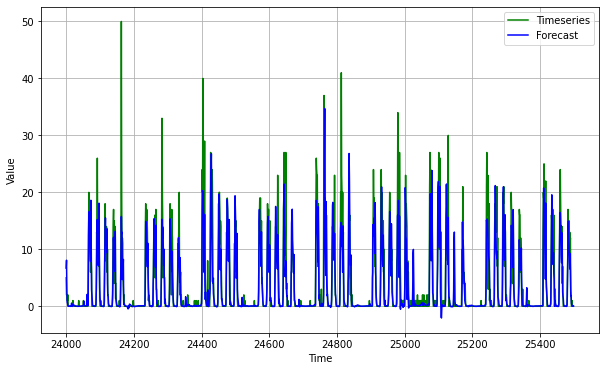

In [0]:
plt.figure(figsize=(10, 6))
start = 0
show_length = 1500
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [0]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model_hourly_v1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_hourly_v1.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
time

'/content/drive/My Drive/HackathonKiel'

In [0]:
len(series)

31058